In [1]:
%matplotlib inline
import pickle
import tensorflow as tf
import gym
import saliency
import numpy as np
from matplotlib import pyplot as P
from tqdm import *
import math
from IPython import display
import tf_cnnvis

from baselines.common.vec_env.vec_frame_stack import VecFrameStack
from baselines.common.cmd_util import make_atari_env
from baselines.a2c.utils import conv_to_fc
from ppo2 import Runner

/home/patcho/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
VISUALIZE_FILTERS = False
ENV_NAME = "AssaultNoFrameskip-v0"#"DemonAttackNoFrameskip-v0"
MODEL_MAKING = 'assault_ppo_seed_0/'
TRAIN_FOLDER = 'assault_seed1_logsave/' # './demon_attack_seed_0/'
ACTION_MAPPING = {
    0: 'NOOP',
    1: 'FIRE',
    2: 'UP',
    3: 'RIGHT',
    4: 'LEFT',
    5: 'RIGHTFIRE',
    6: 'LEFTFIRE',
}

nenv = 8
env = VecFrameStack(make_atari_env(ENV_NAME, nenv, 0), 4)
nact = env.action_space.n

In [3]:
with open(MODEL_MAKING + "make_model.pkl", "rb") as f:
    make_model = pickle.load(f)

In [4]:
tf.Session().__enter__()

model = make_model()
ckpt = 10736
model.load(TRAIN_FOLDER + 'checkpoints/{}'.format(ckpt))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
def conv_copy(x, scope, wold, bold, *, nf, rf, stride, pad='VALID', init_scale=1.0):
    with tf.variable_scope(scope):
        nin = x.get_shape()[3].value
        w = tf.identity(wold)
        b = tf.identity(bold)
        return tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding=pad)+b

def fc_copy(x, scope, nh, wold, bold, *, init_scale=1.0, init_bias=0.0):
    with tf.variable_scope(scope):
        nin = x.get_shape()[1].value
        w = tf.identity(wold)
        b = tf.identity(bold)
        return tf.matmul(x, w)+b   
    
def ShowGrayscaleImage(im, title='', ax=None, pc='', alpha=1):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1, alpha=alpha)
    # P.title(title + str(pc))
    # P.savefig(title + ".png")
    
def ShowHeatImage(im, title='', ax=None, pc='', alpha=1):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.plasma, vmin=0, vmax=1, alpha=alpha)
    # P.title(title + str(pc))
    # P.savefig(title + ".png")
    
def ShowClassImage(im, title='', ax=None, pc='', alpha=1):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.tab10, vmin=0, vmax=1, alpha=alpha)
    # P.title(title + str(pc))
    # P.savefig(title + ".png")
    
def ShowImage(im, title='', ax=None, pc='', alpha=1):
    if ax is None:
        P.figure()
    P.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    P.imshow(im, alpha=alpha)
    # P.title(title + str(pc))
    
def VisualizeImage(image_3d, percentile=99):
    r"""Returns a 3D tensor as a grayscale 2D tensor.

    This method sums a 3D tensor across the absolute value of axis=2, and then
    clips values at a given percentile.
    """
    vmax = np.percentile(image_3d, percentile)
    vmin = np.min(image_3d)

    return np.clip((image_3d - vmin) / (vmax - vmin), 0, 1)

def VisualizeClass(image_3d, num_classes):
    vmax = num_classes
    vmin = 0

    return np.clip((image_3d - vmin) / (vmax - vmin), 0, 1)

In [6]:
graph = tf.get_default_graph()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(None, 84, 84, 4))
    with tf.variable_scope("saliency", reuse=False):
        scaled_images = tf.cast(images, tf.float32) / 255.
        activ = tf.nn.relu
        wold1 = graph.get_tensor_by_name('model/c1/w:0')
        bold1 = graph.get_tensor_by_name('model/c1/b:0')
        h = activ(conv_copy(scaled_images, 'c1', wold1, bold1, nf=32, rf=8, stride=4))
        wold2 = graph.get_tensor_by_name('model/c2/w:0')
        bold2 = graph.get_tensor_by_name('model/c2/b:0')
        h2 = activ(conv_copy(h, 'c2', wold2, bold2, nf=64, rf=4, stride=2))
        wold3 = graph.get_tensor_by_name('model/c3/w:0')
        bold3 = graph.get_tensor_by_name('model/c3/b:0')
        h3 = activ(conv_copy(h2, 'c3', wold3, bold3, nf=64, rf=3, stride=1))
        h3 = conv_to_fc(h3)
        wold4 = graph.get_tensor_by_name('model/fc1/w:0')
        bold4 = graph.get_tensor_by_name('model/fc1/b:0')
        h4 = activ(fc_copy(h3, 'fc1', 512, wold4, bold4))
        wold5 = graph.get_tensor_by_name('model/pi/w:0')
        bold5 = graph.get_tensor_by_name('model/pi/b:0')
        logits = fc_copy(h4, 'pi', nact, wold5, bold5)
        
        neuron_selector = tf.placeholder(tf.int32)
        y_softmax = tf.gather(logits, 0)
        y_selected = y_softmax[neuron_selector]
        prediction = tf.argmax(logits, 1)[0]

In [7]:
sess = tf.get_default_session()
# [print(n.name) for n in tf.get_default_graph().as_graph_def().node]

In [8]:
obs = np.zeros((nenv,) + env.observation_space.shape, dtype=model.train_model.X.dtype.name)
obs[:] = env.reset()
states = model.initial_state
dones = [False for _ in range(nenv)]


In [9]:
def getActivations(layer,stimuli):
    units = sess.run(layer, feed_dict = {images: stimuli})
    plotNNFilter(units)
    

def plotNNFilter(units):
    filters = units.shape[3]
    P.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        P.subplot(n_rows, n_columns, i+1)
        P.title('Filter ' + str(i))
        P.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

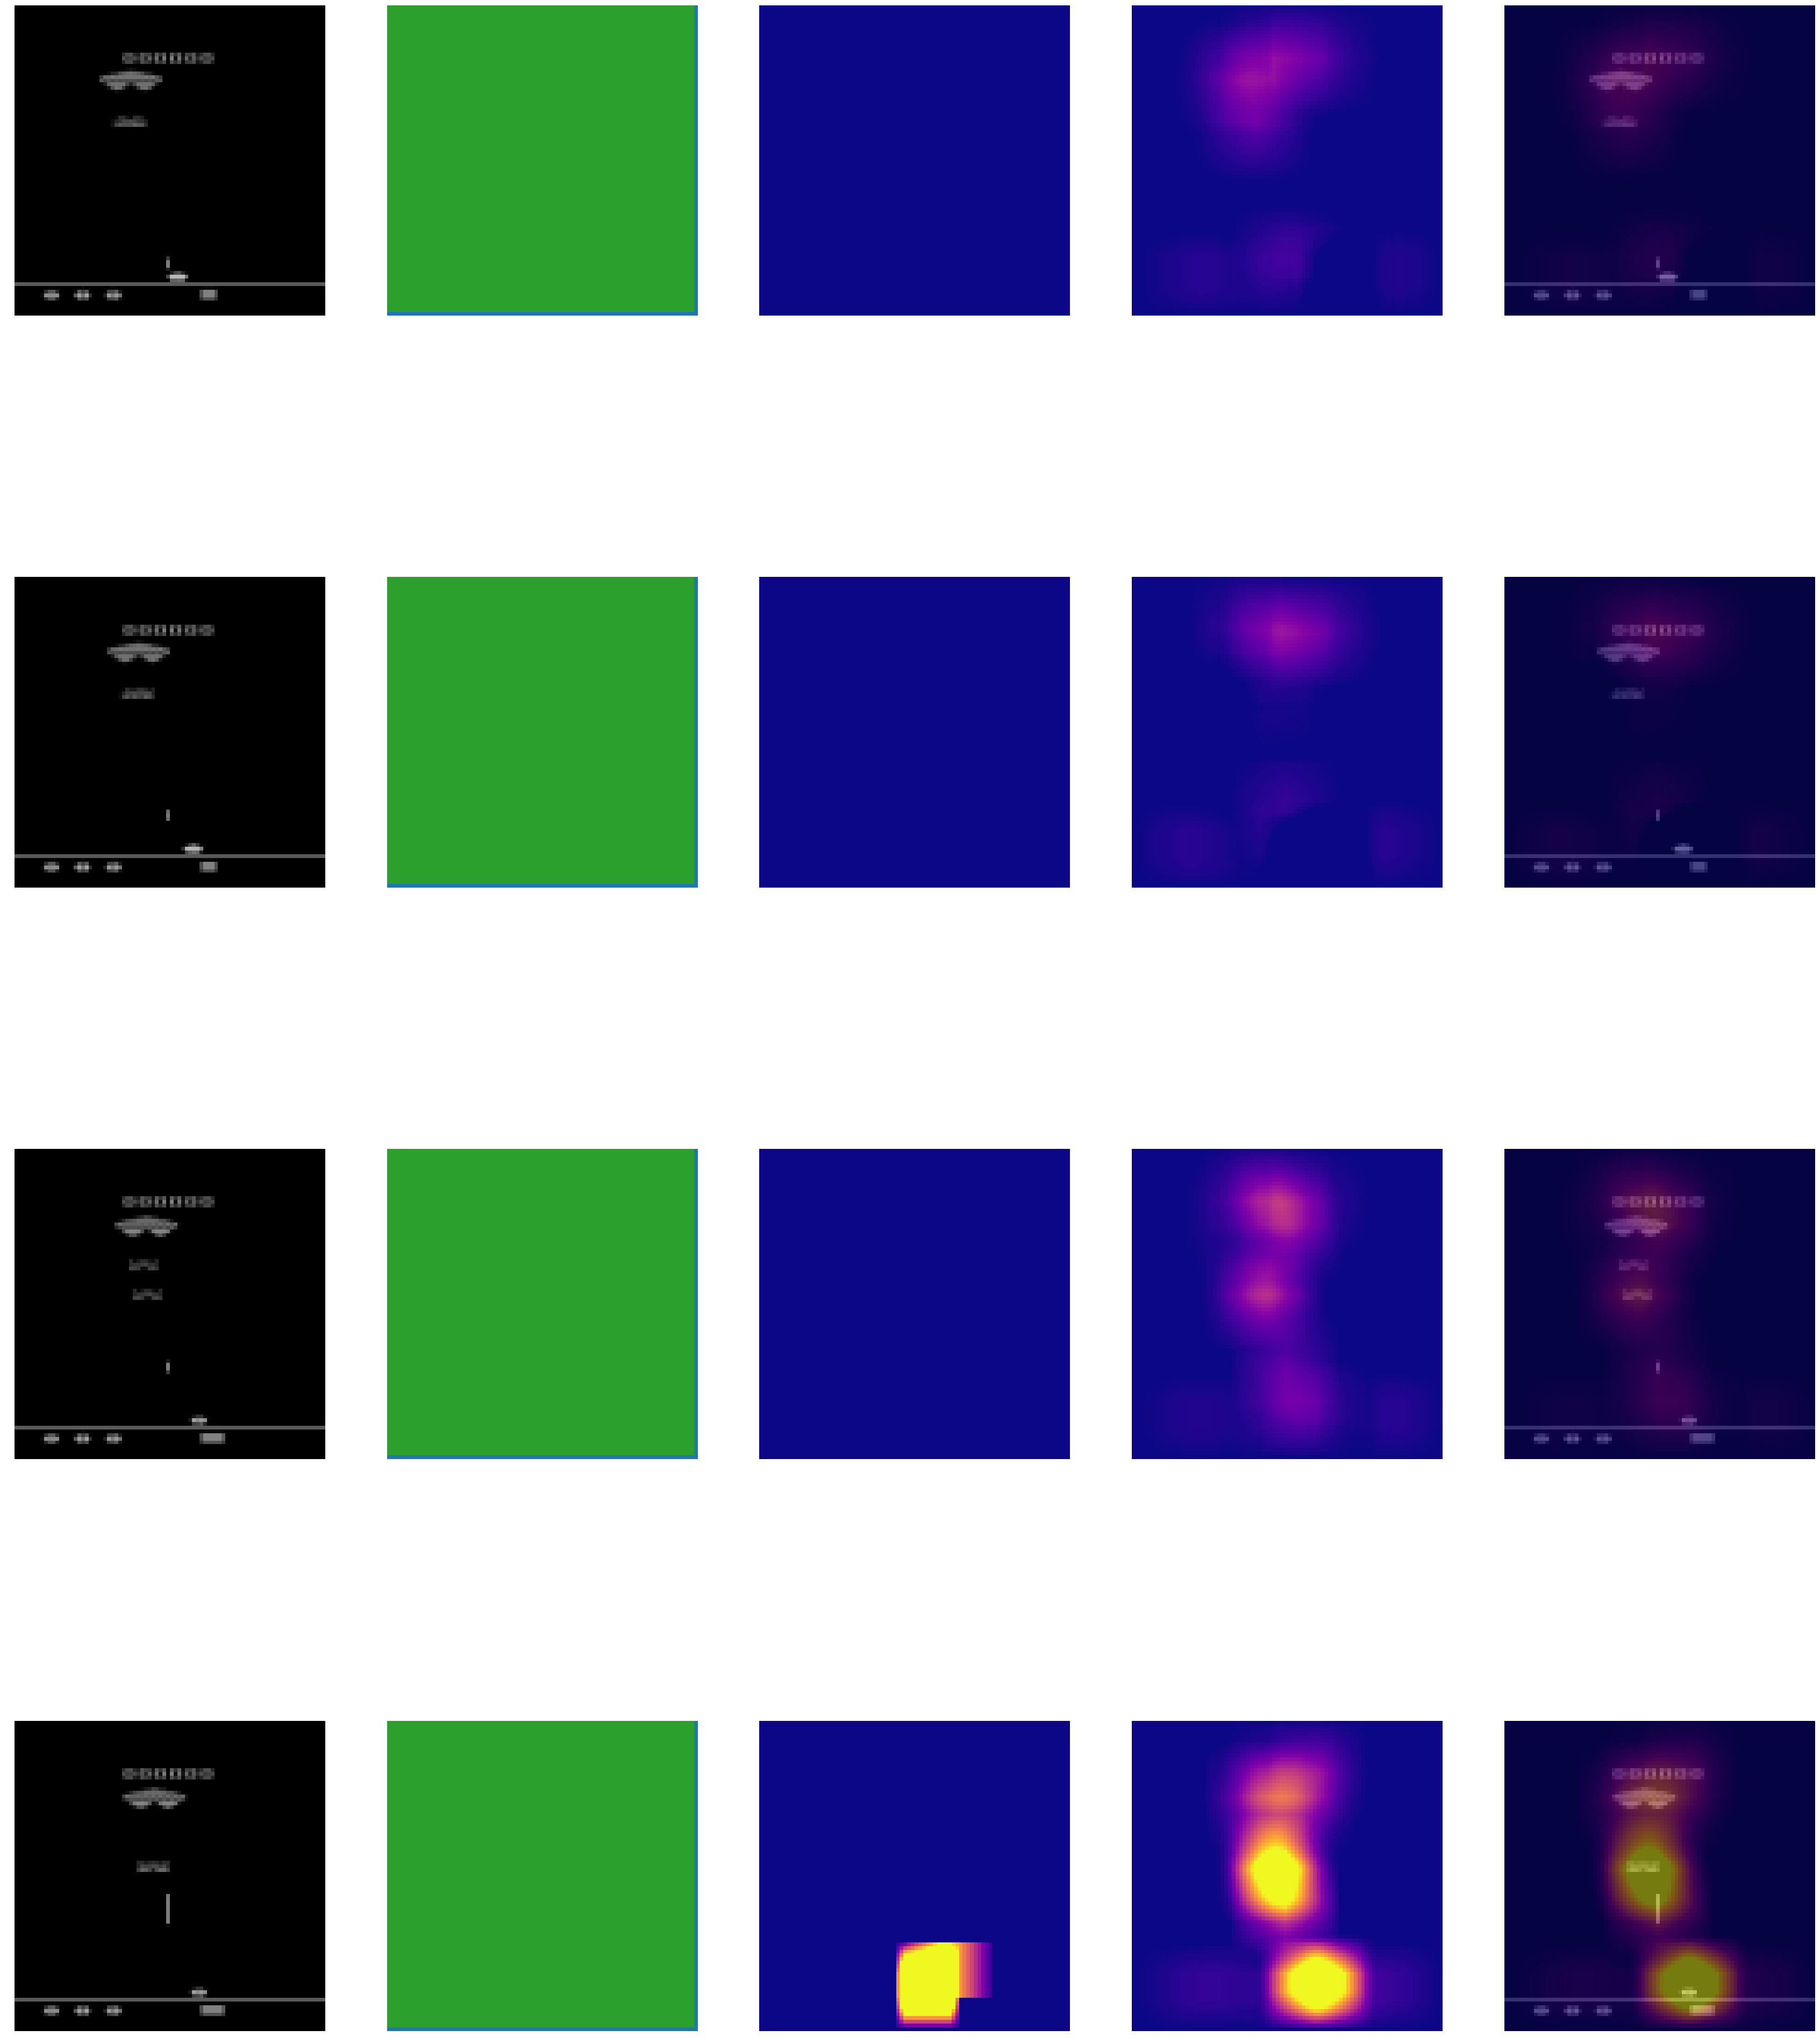

[-0.04954983 -0.60818183  6.1225233   1.7161961  -2.1050634  -5.1514306
 -5.549621  ],[[-0.04954963 -0.6081817   6.122524    1.7161961  -2.1050627  -5.15143
  -5.5496216 ]]
Time: 4 	 Action: UP


In [ ]:
ROWS = 4
COLS = 5
UPSCALE_FACTOR = 15
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR)) 
NUM_STEPS = 10000000
SAVE_FRAME_DIRECTORY = TRAIN_FOLDER + "frames{}".format(ckpt)
if not os.path.exists(SAVE_FRAME_DIRECTORY):
    os.makedirs(SAVE_FRAME_DIRECTORY)

# gradient_saliency = saliency.GradientSaliency(graph, sess, y_selected, images)
# guided_backprop = saliency.GuidedBackprop(graph, sess, y_selected, images)
occlusion = saliency.Occlusion(graph, sess, y_selected, prediction, images)

for i in range(NUM_STEPS):
    actions, values, states, neglogpacs = model.step(obs, states, dones)
    obs[:], rewards, dones, infos = env.step(actions)
    

    ##### DEBUG CODE TO CHECK THAT COMPUTED PROBABILITIES ARE THE SAME #################
    # correct_logits = sess.run(model.act_model.pi, feed_dict={model.act_model.X: obs})
    # logits_ = sess.run(logits, feed_dict={images:[obs[0]]})
    # print("{},{}".format(correct_logits[0], logits_))
    ####################################################################################
    
    prediction_class = sess.run(prediction, feed_dict = {images: [obs[0]]})
    print("Time: {} \t Action: {}".format(i, ACTION_MAPPING[prediction_class]))
    if VISUALIZE_FILTERS:
        with sess.as_default():
            tf_cnnvis.deconv_visualization(sess_graph_path = None, value_feed_dict = {images: [obs[0]]}, 
                                           layers=['saliency/Relu', 'saliency/Relu_1', 'saliency/Relu_2', 'saliency/Relu_3'], 
                                           path_logdir='./viz_log', path_outdir='./viz_output')
            tf_cnnvis.deepdream_visualization(sess_graph_path = None, value_feed_dict = {images: [obs[0]]}, 
                                           layer='saliency/Gather', classes=[prediction_class],
                                           path_logdir='./deepdream_log', path_outdir='./deepdream_output')
    
#     vanilla_mask_3d = gradient_saliency.GetMask(obs[0], feed_dict = {neuron_selector: prediction_class})
#     vanilla_mask = VisualizeImage(vanilla_mask_3d)

#     vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(obs[0], feed_dict = {neuron_selector: prediction_class})
#     vanilla_mask_guided = VisualizeImage(vanilla_guided_backprop_mask_3d)
    
    abs_diff, diff, not_same, max_class = occlusion.GetMask(obs[0].astype(np.float32), feed_dict = {neuron_selector: prediction_class}, value=0)
    abs_diff_mask = VisualizeImage(abs_diff)
    diff = np.clip(diff, 0, None) # Only consider scenarios in which probability of correct class falls
    diff_mask = VisualizeImage(diff)
    not_same_mask = VisualizeImage(not_same)
    max_class_mask = VisualizeClass(max_class, 9)

    for frame in range(4):
        ShowGrayscaleImage(obs[0][:,:,frame].astype(np.float32)/255., title='original', ax=P.subplot(ROWS, COLS, frame * COLS + 1))
        ShowGrayscaleImage(obs[0][:,:,frame].astype(np.float32)/255., title='overlay', ax=P.subplot(ROWS, COLS, frame * COLS + 5))
        ShowClassImage(max_class_mask[:,:,frame], title='occlusion max class', pc=prediction_class, ax=P.subplot(ROWS, COLS, frame * COLS + 2))
        ShowHeatImage(not_same_mask[:,:,frame], title='occlusion class change', pc=prediction_class, ax=P.subplot(ROWS, COLS, frame * COLS + 3))
        ShowHeatImage(diff_mask[:,:,frame], title="occlusion probability change", pc=prediction_class, ax=P.subplot(ROWS, COLS, frame * COLS + 4))
        ShowHeatImage(diff_mask[:,:,frame], title="overlay", pc=prediction_class, ax=P.subplot(ROWS, COLS, frame * COLS + 5), alpha=0.5)
    
    display.clear_output(wait=True)
    display.display(P.gcf())
    P.savefig(SAVE_FRAME_DIRECTORY)
    